In [1]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import numpy as np
import random
import pathlib
import pandas as pd
import seaborn as sns
DATA_ROOT = 'data/stage_1/train/'
sns.set(style="white", palette="muted", color_codes=True)

### Dataset loading function ###

In [2]:
def load_train_images_path(root):
    images = {}
    for image_name in os.listdir(root):
        masks_path = os.path.join(root, image_name, 'masks') 
        masks = [os.path.join(masks_path, mask_name) for mask_name in os.listdir(masks_path) if mask_name.endswith('.png')]
        image_path = os.path.join(root, image_name, 'images', image_name) + '.png'
        if not os.path.exists(image_path):
            raise Exception("invalid data")
        images[image_path] = masks
    return images

In [3]:
masks_by_image = load_train_images_path(DATA_ROOT)
images_paths = list(masks_by_image.keys())

In [4]:
def load_image(image_path):
    im = cv2.imread(image_path)
    return im

def load_mask(image_path):
    im = np.sum([cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in masks_by_image[image_path]], axis=0) / 255
    return im

def load_mask_labels(image_path, im_shape):
    true_labels = np.zeros(im_shape)
    for idx, mask_path in enumerate(masks_by_image[image_path]):
        true_labels[cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) == 255] = idx
    return true_labels

### Visualizing Training Images ###

In [5]:
COLS = 5
ROWS = 5

images_indices = np.random.randint(0, len(images_paths), size=COLS * ROWS)

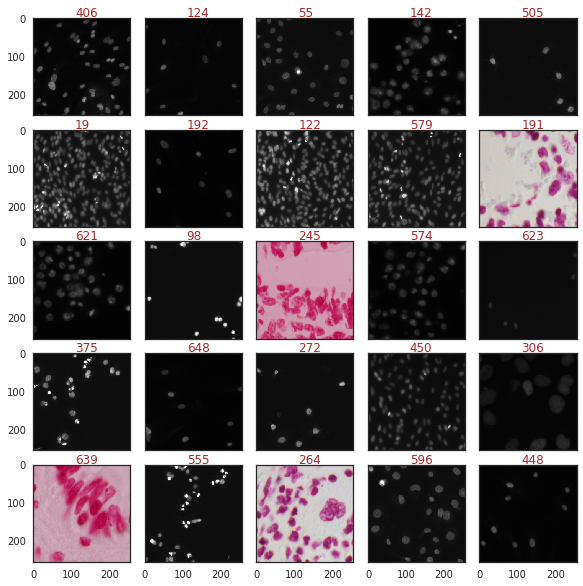

In [6]:
fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(ROWS, COLS),  # creates 2x2 grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 )

for i, idx in enumerate(np.nditer(images_indices)):
    image_path = images_paths[idx]
    im = load_image(image_path) / 255
    im = cv2.resize(im, (256, 256))
    grid[i].imshow(im)
    grid[i].text(110,-5,str(idx),color='brown')
plt.show()

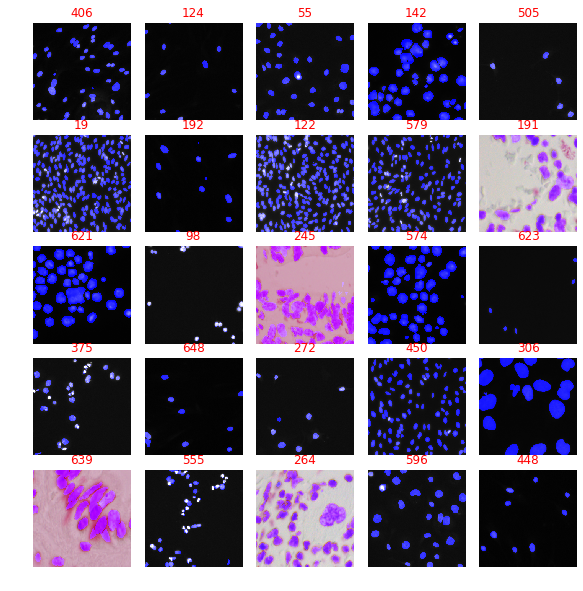

In [7]:
fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(ROWS, COLS),  # creates 2x2 grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 )

for i, idx in enumerate(np.nditer(images_indices)):
    image_path = images_paths[idx]
    im = load_image(image_path)
    im = cv2.resize(im, (256, 256))
    
    mask = load_mask(image_path)
    mask = cv2.resize(mask, (256, 256))
    im[...,2] = im[...,2] * (1-mask) + mask * 255
    
    grid[i].axis('off')
    grid[i].set_title(str(idx), color='red')
    grid[i].imshow(im)
plt.show()

### Cluster microscope technique type ###

Now, unsupervisedly we cluster the images by microscope technique type with K-Means using only mean of the image in hue, saturation, value color mode.

In [8]:
image_means = []

for image_path in images_paths:
    im = load_image(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)# / np.array([180, 255, 255])
    image_means.append(im.mean(axis=(0,1)))
image_means = np.asarray(image_means)

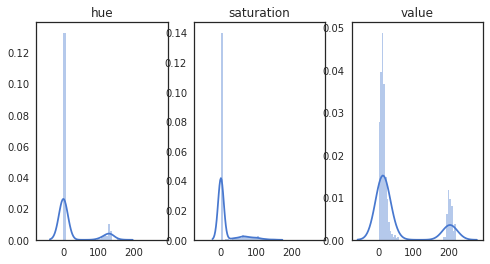

In [9]:
f, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True)
for i in range(3):
    sns.distplot(image_means[...,i], kde=True, ax=axes[i])
    axes[i].set_title(['hue', 'saturation', 'value'][i])
plt.show()

In [10]:
from sklearn.cluster import KMeans

In [11]:
microscope_detector = KMeans(n_clusters=3, random_state=0).fit(image_means)
microscope_detector.labels_

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1,
       0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,

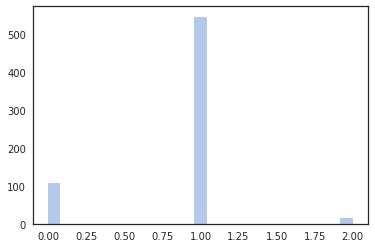

In [13]:
sns.distplot(microscope_detector.labels_, kde=False)
plt.show()

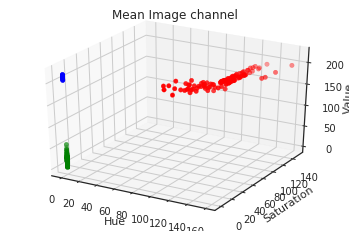

In [14]:
from mpl_toolkits.mplot3d import Axes3D

colors_dict = ['red', 'green', 'blue']
colors = [colors_dict[l] for l in microscope_detector.labels_]

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Mean Image channel')
ax.scatter(image_means[...,0], image_means[...,1], image_means[...,2], c=colors)
ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value')
plt.show()

Lets plot some image as we did before but categorizing it by microscope type

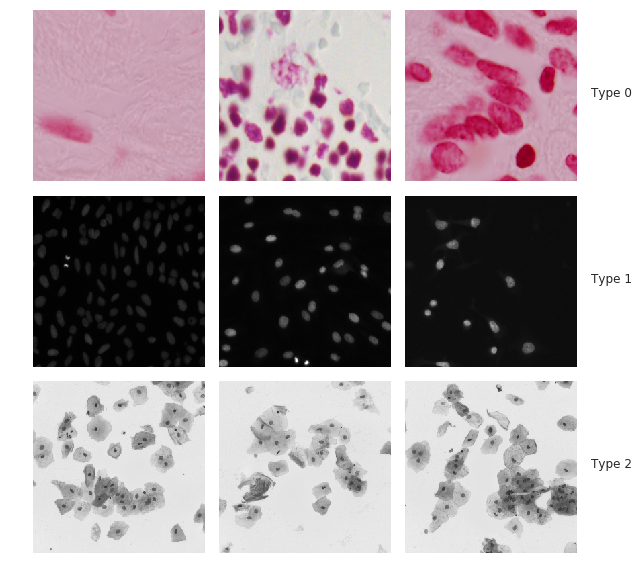

In [15]:
from itertools import islice
    
index_of_samples_by_type = [list(microscope_detector.labels_ == i) for i in range(3)]

COLS = 4
ROWS = 3

fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(ROWS, COLS),  # creates 2x2 grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 )
i = 0
for t in range(ROWS):
    indices = filter(lambda x: index_of_samples_by_type[t][x], range(200))
    
    for idx in islice(indices, COLS-1):
        image_path = images_paths[idx]
        im = load_image(image_path)
        im = cv2.resize(im, (256, 256))
        
        grid[i].axis('off')
        grid[i].imshow(im)
        i += 1
    
    grid[i].text(0, 128, 'Type {}'.format(t))
    grid[i].axis('off')
    i += 1
plt.title('x')
plt.show()

### Finding range ###

In [16]:
def detect_microscope(im):
    return microscope_detector.predict(np.expand_dims(im.mean(axis=(0,1)), axis=0))[0]

In [17]:
from sklearn.model_selection import train_test_split
training, validation = train_test_split(images_paths, test_size=0.33)

In [18]:
def load_dataset(images_paths):
    df = pd.DataFrame({'hue' : [],
                       'saturation' : [],
                       'value' : [],
                       'microscope_type' : [],
                       'object' : []})
    for image_path in training:
        im = load_image(image_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
        m_type = detect_microscope(im)
        mask = load_mask(image_path)
        mask = np.expand_dims(mask, 2).repeat(3, 2)
        masked_im = np.ma.array(im, mask=(mask == 0.0))
        masked_bg = np.ma.array(im, mask=(mask == 1.0))
        mean = masked_im.mean(axis=(0,1))
        bg_mean = masked_bg.mean(axis=(0,1))
        df = df.append({'hue' : mean[0],
                        'saturation' : mean[1],
                        'value' : mean[2],
                        'microscope_type' : m_type,
                        'object' : 'nuclei'}, ignore_index=True)
        df = df.append({'hue' : bg_mean[0],
                        'saturation' : bg_mean[1],
                        'value' : bg_mean[2],
                        'microscope_type' : m_type,
                        'object' : 'background'}, ignore_index=True)
    return df

In [19]:
training_df = load_dataset(training)
validation_df = load_dataset(validation)

In [20]:
training_df.groupby(['microscope_type', 'object']).describe(percentiles=[])

hue                                     \
                            count        mean        std         min   
microscope_type object                                                 
0.0             background   75.0  124.688689  13.966632   93.722974   
                nuclei       75.0  134.153264   4.078345  128.549127   
1.0             background  361.0    0.000000   0.000000    0.000000   
                nuclei      361.0    0.000000   0.000000    0.000000   
2.0             background   12.0    0.000000   0.000000    0.000000   
                nuclei       12.0    0.000000   0.000000    0.000000   

                                                   saturation              \
                                   50%         max      count        mean   
microscope_type object                                                      
0.0             background  131.610224  155.913849       75.0   50.903418   
                nuclei      132.206311  147.129535       75.0  151.784201   
1.0             background    0.000000    0.000000      361.0    0.000000   
                nuclei        0.000000    0.000000      361.0    0.000000   
2.0             background    0.000000    0.000000       12.0    0.000000   
                nuclei        0.000000    0.000000       12.0    0.000000   

                                                                          \
                                  std        min         50%         max   
microscope_type object                                                     
0.0             background  25.770912  10.032509   60.511328  118.135116   
                nuclei      27.257290  82.468300  142.984060  207.866327   
1.0             background   0.000000   0.000000    0.000000    0.000000   
                nuclei       0.000000   0.000000    0.000000    0.000000   
2.0             background   0.000000   0.000000    0.000000    0.000000   
                nuclei       0.000000   0.000000    0.000000    0.000000   

                            value                                     \
                            count        mean        std         min   
microscope_type object                                                 
0.0             background   75.0  206.163506   5.604867  198.160318   
                nuclei       75.0  186.839887  11.994348  154.095410   
1.0             background  361.0    8.674106   5.848638    0.629597   
                nuclei      361.0   57.943308  33.066505   17.267841   
2.0             background   12.0  214.558650   3.953305  207.847413   
                nuclei       12.0  102.797378  10.150086   87.501489   

                                                    
                                   50%         max  
microscope_type object                              
0.0             background  206.211722  222.621502  
                nuclei      188.599301  205.664967  
1.0             background    6.211067   38.491289  
                nuclei       49.056447  187.251309  
2.0             background  215.433614  219.092193  
                nuclei      103.271372  121.821679

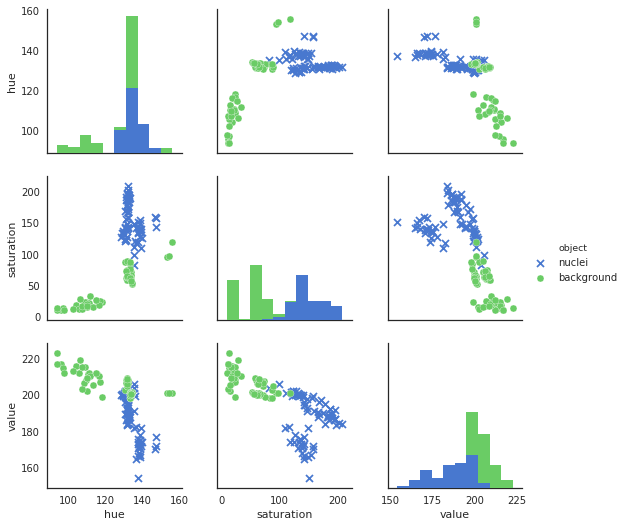

In [21]:
sns.pairplot(data=training_df[training_df['microscope_type'] == 0], kind='scatter',hue='object', markers=['x', 'o'], vars=['hue', 'saturation', 'value'])
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


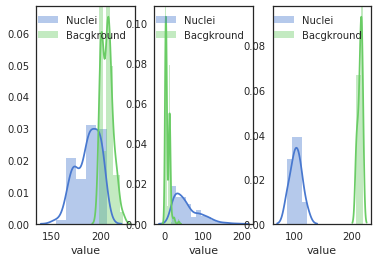

In [22]:
for i in range(3):
    plt.subplot(1,3,i+1); sns.distplot(training_df[training_df['microscope_type'] == i][training_df['object']=='nuclei']['value'], label='Nuclei')
    plt.subplot(1,3,i+1); sns.distplot(training_df[training_df['microscope_type'] == i][training_df['object']=='background']['value'], label='Bacgkround')
    plt.legend()
plt.show()

In [23]:
from sklearn import svm
from sklearn import preprocessing

scalers = [preprocessing.StandardScaler(), preprocessing.StandardScaler(), preprocessing.StandardScaler()]
models = [svm.SVC(), svm.SVC(), svm.SVC()]

In [24]:
images_path_by_m_type = [list(microscope_detector.labels_ == i) for i in range(3)]

for image_path in images_paths:
    im = load_image(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)# / np.array([180, 255, 255])
    m_type = microscope_detector.predict(np.expand_dims(im.mean(axis=(0,1)), axis=0))[0]
    X_train = im.reshape((im.shape[0] * im.shape[1], im.shape[2]))
    Y_train = load_mask(image_path).reshape((im.shape[0] * im.shape[1],))
    X_train = scalers[m_type].fit_transform(X_train)
    models[m_type].fit(X_train, Y_train)

In [189]:
from scipy import ndimage

def predict(im):
    shape = im.shape
    im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    m_type = detect_microscope(im)
    #im = im.reshape(shape[0] * shape[1], shape[2])
    hue = im[...,0]
    sat = im[...,1]
    val = im[...,2]
    
    if m_type == 0:
        _, output = cv2.threshold(sat, 200, 255, cv2.THRESH_BINARY)
    elif m_type == 1:
        _, output = cv2.threshold(val, 22, 164, cv2.THRESH_BINARY)
    else:
        _, output = cv2.threshold(val, 90, 115, cv2.THRESH_BINARY)
    #im = scalers[m_type].transform(im)
    #predicted_mask = models[m_type].predict(im).reshape(shape[0], shape[1])
    return ndimage.label(output)

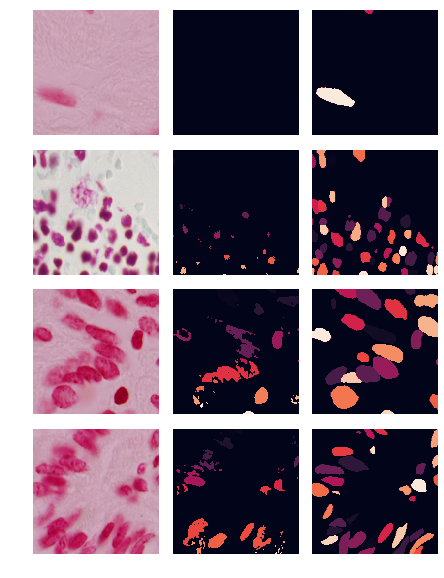

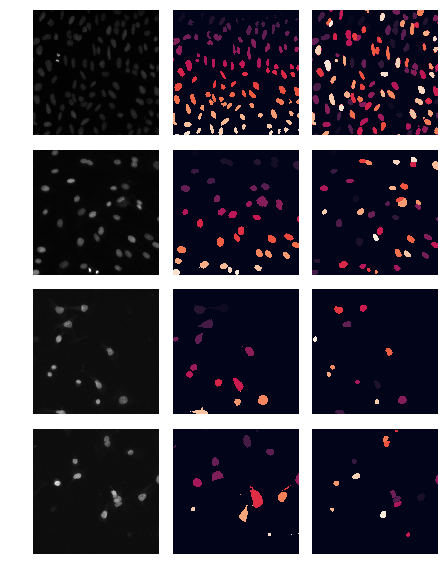

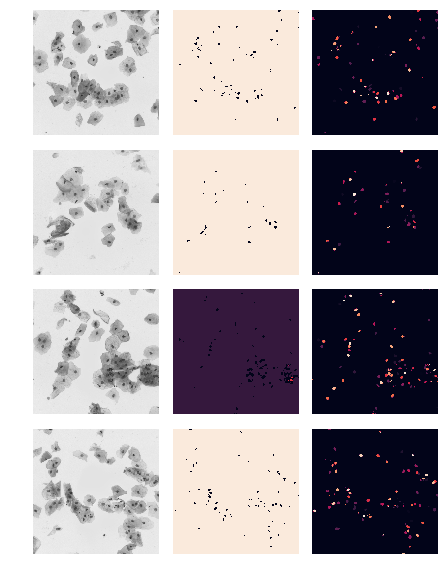

In [190]:
from itertools import islice
    
index_of_samples_by_type = [list(microscope_detector.labels_ == i) for i in range(3)]


i = 0
for t in range(3):
    indices = filter(lambda x: index_of_samples_by_type[t][x], range(200))
    
    
    COLS = 3
    ROWS = 4
    
    fig = plt.figure(1, (10., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(ROWS, COLS),  # creates 2x2 grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 )
    
    for i, idx in enumerate(islice(indices, ROWS)):
        image_path = images_paths[idx]
        im = load_image(image_path)
        mask = load_mask_labels(image_path, (im.shape[0], im.shape[1]))
        im = cv2.resize(im, (256, 256))
        mask = cv2.resize(mask, (256, 256))
        #im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
        labels, _ = predict(im)
        grid[i*3].axis('off')
        grid[i*3].imshow(im)
        grid[i*3+1].axis('off')
        grid[i*3+1].imshow(labels)
        grid[i*3+2].axis('off')
        grid[i*3+2].imshow(mask)
        

    
    plt.show()

In [172]:
image_path = images_paths[364]
im = load_image(image_path)
mask = load_mask(image_path)
im = cv2.resize(im, (256, 256))
mask = cv2.resize(mask, (256, 256))

In [169]:
labels, _ = predict(im)

In [163]:
def iou(labels, y_pred):
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))
    
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

In [164]:
ious = []
for image_path in validation:
    im = load_image(image_path)
    labels, num_labels = predict(im)
    true_labels = load_mask_labels(image_path, labels.shape)
    ious.append(iou(labels, true_labels))

In [165]:
np.mean(ious)

0.18279898663206828

In [ ]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [ ]:
h, w, _ = load_image(images_paths[0]).shape
x = load_mask_labels(images_paths[0], (h, w))